In [2]:
pip install optuna -q


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import optuna

import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split

In [2]:
df = pd.read_csv('base_dt.csv')
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,riders,target_reg,target_class,total_car_age,servis_car_age,...,max_car_speed,count_car_rides,upquart_car_speed,start_car_devnorm,driver_range,active_ride,accident_rate,worker_experience,work_meanduration_car,month_top_carfix
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,76163,108.53,another_bug,8,2,...,180.855726,169.0,105.000000,0.000,1097.0,0.729018,0.007975,275.685714,26.657143,4.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,78218,35.20,electro_bug,8,2,...,187.862734,174.0,109.660112,-7.057,1187.5,0.694342,0.006158,264.628571,24.942857,1.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,23340,38.62,gear_stick,11,6,...,102.382857,165.0,74.000000,0.000,1206.0,0.758170,0.007472,268.314286,26.142857,3.0


In [3]:
df.drop(columns=['car_id'], inplace=True, errors = 'ignore') # Удаляю признак car_id, т.к. он не несет смысловой нагрузки
df['month_top_carfix'] = df['month_top_carfix'].astype(str) # Представляет собой нумерацию месяцев от 1 до 12, что является категориальным признаком
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  2337 non-null   object 
 1   car_type               2337 non-null   object 
 2   fuel_type              2337 non-null   object 
 3   car_rating             2337 non-null   float64
 4   riders                 2337 non-null   int64  
 5   target_reg             2337 non-null   float64
 6   target_class           2337 non-null   object 
 7   total_car_age          2337 non-null   int64  
 8   servis_car_age         2337 non-null   int64  
 9   shift_car_devnorm      2337 non-null   float64
 10  min_car_rating         2337 non-null   float64
 11  mean_car_rating        2337 non-null   float64
 12  sum_car_distance       2337 non-null   float64
 13  max_car_speed          2337 non-null   float64
 14  count_car_rides        2337 non-null   float64
 15  upqu

In [4]:
drop_cols = ['target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'month_top_carfix']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

In [5]:
from sklearn.metrics import accuracy_score

def objective(trial, return_models=False):
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data) # Определили выше
        scores.append(accuracy_score(y_pred, valid_data[1]))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [6]:
def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'iterations' : 500, # Можно не перебирать, есть Early-Stopping
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.01),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "depth": trial.suggest_int("depth", 3, 9),
        
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "14gb",
        "eval_metric": "Accuracy", # Тоже стоит заранее определиться
    }

    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=42,
        cat_features=cat_cols,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=50,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [7]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=600,
               n_jobs = -1,
               show_progress_bar=True,)

[I 2024-07-10 08:50:07,252] A new study created in memory with name: no-name-b283bd7b-62c4-4417-bee8-14b537cfe5b6


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2024-07-10 08:50:30,670] Trial 0 finished with value: 0.9520753102267864 and parameters: {'learning_rate': 0.005600530693603259, 'l2_leaf_reg': 33, 'colsample_bylevel': 0.28717020441904384, 'auto_class_weights': 'Balanced', 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9520753102267864.
[I 2024-07-10 08:50:35,257] Trial 1 finished with value: 0.9550706033376124 and parameters: {'learning_rate': 0.0018757559221708156, 'l2_leaf_reg': 30, 'colsample_bylevel': 0.21280516656434648, 'auto_class_weights': 'Balanced', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6448952981415819}. Best is trial 1 with value: 0.9550706033376124.
[I 2024-07-10 08:50:50,765] Trial 3 finished with value: 0.9580658964484382 and parameters: {'learning_rate': 0.0023674044260536273, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.4557898199807569, 'auto_class_weights': 'SqrtBalanced', 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_t

In [8]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9717586649550706, params {'learning_rate': 0.009785271335404784, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.1492560605194073, 'auto_class_weights': 'SqrtBalanced', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [13]:
valid_scores, models = objective(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True,
)

In [45]:
n=1
for model in models:
    accuracy = model.score(X, y)
    print(f"model {n} Accuracy: {accuracy:.5f}")
    n+=1

model 1 Accuracy: 0.97133
model 2 Accuracy: 0.97304
model 3 Accuracy: 0.96962


In [10]:
trials_df = study.trials_dataframe().sort_values('value', ascending=False)
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_auto_class_weights,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_subsample,state
483,483,0.971759,2024-07-10 09:36:49.017980,2024-07-10 09:37:07.114614,0 days 00:00:18.096634,SqrtBalanced,NaN,Plain,MVS,0.149256,6,2,0.009785,NaN,COMPLETE
124,124,0.970903,2024-07-10 09:07:44.601518,2024-07-10 09:07:59.116133,0 days 00:00:14.514615,SqrtBalanced,NaN,Plain,MVS,0.115056,6,2,0.009188,NaN,COMPLETE
539,539,0.970903,2024-07-10 09:41:31.951781,2024-07-10 09:41:49.826160,0 days 00:00:17.874379,SqrtBalanced,NaN,Plain,MVS,0.133366,6,3,0.009231,NaN,COMPLETE
227,227,0.970475,2024-07-10 09:15:04.570226,2024-07-10 09:15:29.954872,0 days 00:00:25.384646,SqrtBalanced,NaN,Plain,MVS,0.133917,6,2,0.008559,NaN,COMPLETE
309,309,0.970475,2024-07-10 09:22:09.100368,2024-07-10 09:22:26.943822,0 days 00:00:17.843454,SqrtBalanced,NaN,Plain,MVS,0.149234,6,3,0.009048,NaN,COMPLETE


##### В результате тестирования на всем датасете лучший accuracy- 0.97304 и лучших параметрах:
  {'learning_rate': 0.009785271335404784, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.1492560605194073, 'auto_class_weights': 'SqrtBalanced', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

Всего признаков 21 Усреднее по 3-ти моделям: 
На график нанесено топ-15 признаков


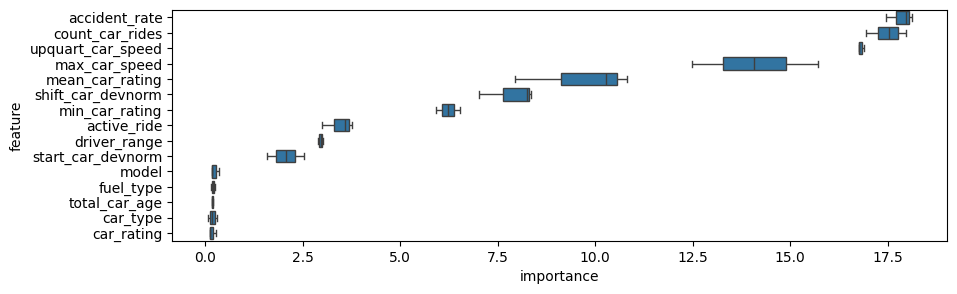

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    X,
    best_model = models,
    height = 0.20,
    top_n=15,
)

#### Важность признаков согласуется с предыдущими исследованиями. Хочу отметить обобщающие признаки, как upquart_car_speed, имеет меньший зазброс и показало на усредненных значениях большую значимость. Из этого могу сделать вывод, что такие признаки дадут более стабильное предсказание

In [28]:
pip install optuna-dashboard -q


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install optuna plotly tenacity -q


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install --upgrade optuna plotly -q


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
!pip uninstall tenacity -y
!pip install tenacity

Found existing installation: tenacity 8.4.0
Uninstalling tenacity-8.4.0:
  Successfully uninstalled tenacity-8.4.0

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [42]:
import optuna
import optuna.visualization

# Проверка, какие версии установлены
import plotly
import tenacity

print("Optuna version:", optuna.__version__)
print("Plotly version:", plotly.__version__)
print("Tenacity version:", tenacity.__version__)

AttributeError: partially initialized module 'tenacity' has no attribute 'stop' (most likely due to a circular import)

In [33]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

ModuleNotFoundError: No module named 'tenacity.asyncio'

ModuleNotFoundError: No module named 'tenacity.asyncio'

ModuleNotFoundError: No module named 'tenacity.asyncio'

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 597, 598, 599],
              'y': [0.9520753102267864, 0.9550706033376124, 0.9482242190842961,
                    ..., 0.9670517757809156, 0.8600770218228497, 0.965768078733419]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, ..., 597, 598, 599],
              'y': [0.9520753102267864, 0.9550706033376124, 0.9550706033376124,
                    ..., 0.9717586649550706, 0.9717586649550706,
                    0.9717586649550706]},
             {'marker': {'color': '#cccccc'},
              'mode': 'markers',
              'name': 'Infeasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'

In [35]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

ModuleNotFoundError: No module named 'tenacity.asyncio'

ModuleNotFoundError: No module named 'tenacity.asyncio'

ModuleNotFoundError: No module named 'tenacity.asyncio'

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [boosting_type (CategoricalDistribution):
                                0.0018110246220411305<extra></extra>, depth
                                (IntDistribution):
                                0.005585148520732059<extra></extra>, l2_leaf_reg
                                (IntDistribution):
                                0.006011897827101723<extra></extra>, bootstrap_type
                                (CategoricalDistribution):
                                0.02596248320302772<extra></extra>,
                                auto_class_weights (CategoricalDistribution):
                                0.02921823457536202<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.05125014668970636<extra></extra>,
                                colsample_bylevel (FloatDistribution):
                                0.8801610645620288<extra></ex